# Práctica 3: Redes neuronales convolucionales para clasificación de imágenes

En esta práctica, vamos a utilizar modelos profundos para clasificar dígitos manuscritos, de forma similar al práctico 1. En este caso, utilizaremos el dataset MNIST donde los dígitos poseen un tamaño de 28x28 (en lugar de 8x8 como en dicho práctico). 

Para eso, comenzamos por cargar y visualizar el dataset:

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import torchvision
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sys 
sys.path.append(os.path.abspath('subdir'))
from utils import aux

In [6]:
aux()

Holaa 


/usr/lib/python3/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


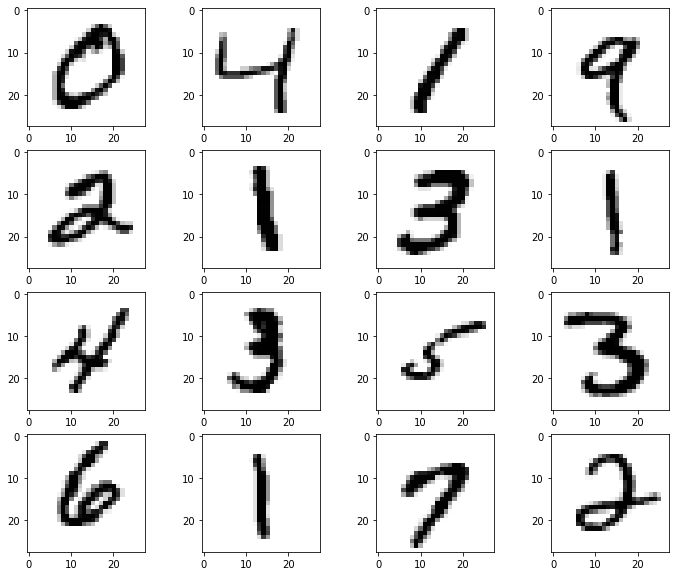

In [2]:
plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', 
                             train=True, 
                             download=True, 
                             transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', 
                            train=False, 
                            download=True, 
                            transform=torchvision.transforms.ToTensor())

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))
    

# Perceptrón multicapa

Primero, vamos a adaptar el perceptrón mutlicapa implementado en la práctica anterior, para que pueda clasificar imágenes de 28 x 28 en 10 categorías diferentes. Para ello, deberemos realizar algunos cambios:

* Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28, a un vector de 784 componetes. Para ello, utilziaremos el método `view` de los tensores de Pytorch.

* Utilizaremos un perceptrón con 15 neuronas en las capas intermedias.

* La última capa deberá tener 10 neuronas (en lugar de 1 sola como tenia el perceptrón multicapa que utilizamos para hacer regresión).

* Deberemos cambiar la función de pérdida. En este caso, utilizaremos Entropía Cruzada (`torch.nn.CrossEntropyLoss`)

In [3]:
class NetMLP(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(NetMLP, self).__init__()
        self.input_features = input_features
        self.hidden1 = nn.Linear(input_features,size_hidden)
        self.hidden2 = nn.Linear(size_hidden,size_hidden)
        self.out = nn.Linear(size_hidden,n_output)

    def forward(self, x):
        x = x.view(-1, self.input_features)
        x = F.relu(self.hidden1(x))         # linear output
        x = F.relu(self.hidden2(x))
        output = F.softmax(self.out(x),dim=1) 
        return output

In [4]:
# Definimos el modelo del perceptrón
input_features = 28*28
hidden_neurons = 15
num_outputs = 10

# Tamaño del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

In [12]:
net = NetMLP(input_features, hidden_neurons, num_outputs)
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss()
#criterion.to(device)

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader=DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)

# Número de épocas
#num_epochs = 5

#trainer(net,criterion,loader,optimizer,num_epochs = 5)


NameError: name 'trainer' is not defined

### Guardamos el modelo para poder reutilizarlo

In [44]:
torch.save(net.state_dict(), "./mlp21.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [13]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
net = NetMLP(input_features,hidden_neurons,num_outputs)
net.load_state_dict(torch.load("./mlp20.pth"))
net.to(device)

NetMLP(
  (hidden1): Linear(in_features=784, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=10, bias=True)
)

In [14]:
showTestResults(net)

NameError: name 'showTestResults' is not defined

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (`nn.Conv2D`) (6 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa convolucional (`nn.Conv2D`) (16 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa totalmente conectada (`nn.Linear`) (120 neuronas) + ReLU
* Capa totalmente conectada (`nn.Linear`) (84 neuronas) + ReLU
* Capa de salida (`nn.Linear`) (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


self.conv1 = nn.Conv2D(out_channels=6)
self.conv2 = ...
self.fc1 = ...
self.fc2 = ...
self.fc3 = ...

In [50]:
class NetCNN(nn.Module):
    def __init__(self,kernel_s,strides,n):
        ks1, ks2 = kernel_s 
        s1,s2 = strides
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                             out_channels=6,
                             kernel_size=ks1,stride=s1)
        self.conv2 = nn.Conv2d(in_channels=6,
                             out_channels=16,
                             kernel_size=ks2,stride=s2)
        self.fc1=nn.Linear(16*n*n,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        # Al pasar de capa convolucional a capa totalmente conectada, tenemos
        # que reformatear la salida para que se transforme en un vector unidimensional
        x = x.view(-1,16*n*n)
        #x = x.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x
def train(net):
    # Tamaño del batch de entrenamiento
    batch_size = 50

    # Tasa de aprendizaje inicial para el gradiente descendente
    learning_rate = 0.0001

    # Construimos el optimizador, y le indicamos que los parámetros a optimizar 
    # son los del modelo definido: net.parameters()

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Definimos también la función de pérdida a utilizar
    criterion = torch.nn.CrossEntropyLoss() 

    # Creamos un loader iterable indicandole que debe leer los datos a partir de
    # del dataset creado en el paso anterior. Este objeto puede ser iterado
    # y nos devuelve de a un batch (x, y).
    loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

    # Número de épocas
    num_epochs = 5

    # Lista en la que iremos guardando el valor de la función de pérdida en cada 
    # etapa de entrenamiento
    loss_list = []

    # Bucle de entrenamiento
    for i in range(num_epochs):

        # Itero sobre todos los batches del dataset
        for x, y in loader:
            # Seteo en cero los gradientes de los parámetros a optimizar
            optimizer.zero_grad()

            # Movemos los tensores a memoria de GPU
            x = x.to(device)
            y = y.to(device)

            # Realizo la pasada forward por la red
            loss = criterion(net(x), y)

            # Realizo la pasada backward por la red        
            loss.backward()

            # Actualizo los pesos de la red con el optimizador
            optimizer.step()

            # Me guardo el valor actual de la función de pérdida para luego graficarlo
            loss_list.append(loss.data.item())

        # Muestro el valor de la función de pérdida cada 100 iteraciones        
        #if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, loss))

    # Muestro la lista que contiene los valores de la función de pérdida
    # y una versión suavizada (rojo) para observar la tendencia
    plt.figure()
    loss_np_array = np.array(loss_list)
    plt.plot(loss_np_array, alpha = 0.3)
    N = 60
    running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
    plt.plot(running_avg_loss, color='red')
    plt.title("Función de pérdida durante el entrenamiento")

In [51]:
device = torch.device('cuda:0')
kernels=[5,3] 
strides=[1,1]
n=5

Epoch 0, loss = 1.61929
Epoch 1, loss = 1.51953
Epoch 2, loss = 1.61363
Epoch 3, loss = 1.51837
Epoch 4, loss = 1.51043


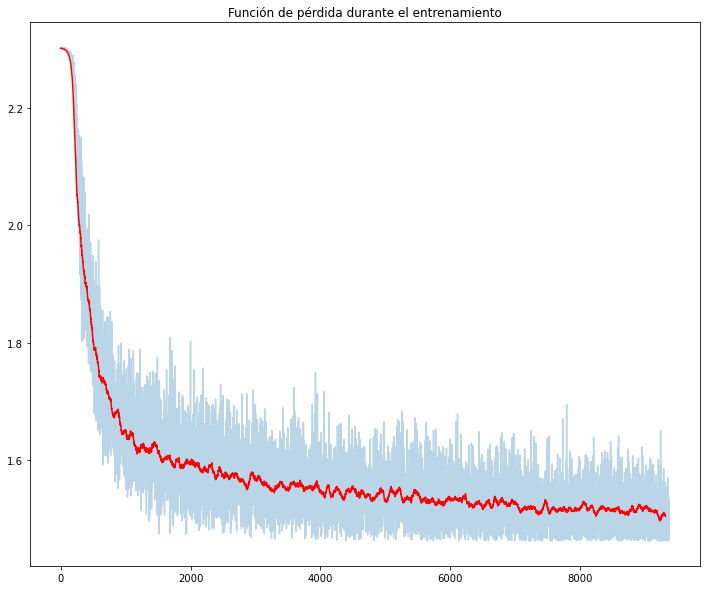

In [52]:
net = NetCNN(kernels,strides,n)
net.to(device)
train(net)

In [ ]:
net2 = NetCNN([])

### Guardo el modelo

In [44]:
torch.save(net.state_dict(), "./cnn21.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [33]:
# Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
net = NetCNN()
net.load_state_dict(torch.load("./cnn20.pth"))
net.to(device)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.97      0.95      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.95      0.96       958
           7       0.95      0.94      0.95      1028
           8       0.93      0.96      0.94       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



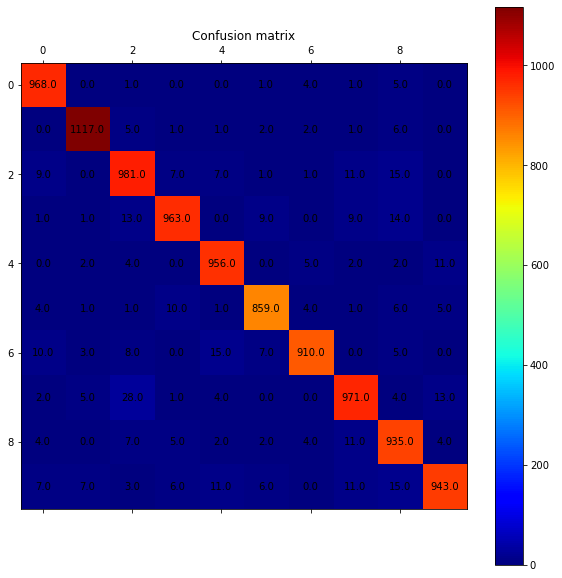

In [53]:
# Mostramos los resultados
showTestResults(net)

# Entregable

1. Implementar el perceptrón multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida por el perceptrón muticapa y la red neuronal convolucional. 

2.  
Calculo para la red conv:
(Para la red que me dio "mejores" resultados)

* input: matriz de 28x28.
* primer capa: kernel de dimesion 5x5 con 6 niveles de profunidad, stride=1 y funcion de activacion ReLU -> 6 matrices de 24x24.
* aplicamos un maxPool de 2x2 (a cada una),stride=2 -> 6 matrices de 12x12.
* se aplica: kernel de 3x3x6 con 16 niveles de profundidad con stride 1, nuevamente con ReLU resultando en 16 matrices de 10x10. 
* aplicamos: maxPooling de 2x2, stride=2 -> 16 matrices de 5x5. 
* aplicamos: view -> 16*5*5 nodos en nuestra capa densa.
* capas ocultas: tamaños 120, 84 y 10(ambas densas), ReLU como funcion de activacion y para la salida, aplicamos softmax.


3.

accuracy(`MLP`) = 0.88 

accuracy(`CNN`) = 0.96